In [4]:
from pathlib import Path
from glob import glob
from bs4 import BeautifulSoup
import cssutils
from PIL import Image
from gutenbergpy.gutenbergcache import GutenbergCache
from IPython.display import display
from shutil import rmtree
import os


from scraping.settings import SETTINGS
from scraping.data import (
    engine,
    async_session,
    save_file_to_s3,
    download_file_from_s3,
    download_and_extract_zip,
    get_css,
)
from scraping.tables import Text, Base

ModuleNotFoundError: No module named 'PIL'

In [3]:
pip install cssutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [cssutils]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scraping 0.1.0 requires bs4, which is not installed.
scraping 0.1.0 requires Pillow, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Run the first time, will take about an hour, it builds the cache which lets us look up books
GutenbergCache.create()

In [ ]:
# Find the books related to childrens picture books
cache = GutenbergCache.get_cache()
query = """
SELECT books.id , subjects.name, titles.name, authors.name,  bookshelves.name, downloadlinks.name
FROM books
INNER JOIN book_subjects bs ON books.id = bs.bookid
INNER JOIN subjects ON bs.subjectid = subjects.id
INNER JOIN languages ON languages.id = books.languageid
INNER JOIN titles ON books.id = titles.bookid
INNER JOIN book_authors ON book_authors.bookid = titles.bookid
INNER JOIN authors ON book_authors.authorid = authors.id
INNER JOIN bookshelves ON bookshelves.id = books.bookshelveid
INNER JOIN downloadlinks ON downloadlinks.bookid = books.id
INNER JOIN downloadlinkstype ON downloadlinks.downloadtypeid = downloadlinkstype.id
WHERE bookshelves.name = "Children's Picture Books"
AND languages.name = 'en'
AND downloadlinks.name LIKE "%.zip"
AND downloadlinkstype.name LIKE "text/html%"
"""
cursor = cache.native_query(query)
books = cursor.fetchall()

# Collect a few samples
all_data = []
min_text_size = 2
max_text_size = 100
seen_books = set()
# Going through whole list will just mean more filtering, you can
for book in books[:2]:
    book_id, subject, title, authors, bookshelf, url = book
    try:
        print(url)
        url_id = str(url.split("/")[-2])

        url = index_url_base = (
            f"http://aleph.gutenberg.org/{url_id[0]}/{url_id[1]}/{url_id[2]}/{url_id[3]}/{url_id}/{url_id}-h.zip"
        )

        base_name = url.split("/")[-2] + "-h"

        file_path = f"{base_name}/{base_name}.htm"
        download_and_extract_zip(url)
        if not os.path.exists(file_path) or base_name in seen_books:
            print(base_name)
            for match in glob("*-h"):
                if os.path.isdir(match):
                    rmtree(match)
                else:
                    os.remove(match)

            continue
        seen_books.add(base_name)
        data_dir = Path(base_name)
        with open(file_path, "r", encoding="latin-1") as fp:
            soup = BeautifulSoup(fp, "html.parser")
            selectors = {}
            for styles in soup.select("style"):
                css = cssutils.parseString(styles.encode_contents())
                for rule in css:
                    if rule.type == rule.STYLE_RULE:  # Check for style rules
                        style = rule.selectorText
                        selectors[style] = {}
                        for item in rule.style:
                            propertyname = item.name
                            value = item.value
                            selectors[style][propertyname] = value
            for p_tag in soup.find_all("pre"):
                p_tag.extract()
            body = soup.find("body")
            has_table_with_img = 0
            for tab in body.find_all("table"):
                if tab.find("img") is not None:
                    has_table_with_img += 1
            if has_table_with_img >= 2:
                tables = body.find_all("table")
                for table in tables:
                    if table.has_attr("class") and "background-image" in get_css(
                        table["class"], selectors
                    ):
                        css = get_css(table["class"], selectors)
                        # print(0)
                        try:
                            image_file_string = (
                                css["background-image"]
                                .replace("url(", "")
                                .replace(")", "")
                            )
                            background_image_file = data_dir / image_file_string

                            background_image = Image.open(background_image_file)
                            if (
                                min_text_size
                                <= len(table.text.strip().split())
                                < max_text_size
                            ):
                                all_data.append(
                                    (
                                        background_image,
                                        table.text.strip(),
                                        len(all_data),
                                        book_id,
                                        subject,
                                        title,
                                        authors,
                                        bookshelf,
                                    )
                                )
                        except Exception as e:
                            print(0, e)
                    elif table.find("img") is not None:
                        # print(1)
                        try:
                            table_image = table.find("img")
                            image_file_string = table_image.attrs["src"]
                            background_image = Image.open(background_image_file)
                            if len(table.text.strip().split()) < max_text_size:
                                all_data.append(
                                    (
                                        background_image,
                                        table.text.strip(),
                                        len(all_data),
                                        book_id,
                                        subject,
                                        title,
                                        authors,
                                        bookshelf,
                                    )
                                )
                        except Exception as e:
                            print(1, e)
                    # else:
                    #     print(table)
            elif len(body.find_all("img")) > 2:
                text_tags = {"p", "h3", "h2", "h1", "span"}
                image = None
                curr_text = ""
                for el in list(body.descendants):
                    if el.name == "img":
                        # print("HERE1")
                        image_file_string = el.attrs["src"]
                        background_image_file = data_dir / image_file_string
                        # print(background_image_file)
                        if image is not None:
                            have_text = curr_text.strip() != ""
                            if (
                                have_text
                                and min_text_size
                                <= len(curr_text.split())
                                < max_text_size
                            ):
                                # texts.append(curr_text)
                                # images.append(image)
                                all_data.append(
                                    (
                                        image,
                                        curr_text,
                                        len(all_data),
                                        book_id,
                                        subject,
                                        title,
                                        authors,
                                        bookshelf,
                                    )
                                )
                            curr_text = ""
                        image = Image.open(background_image_file)
                        # print(image)
                    elif (
                        el.name in text_tags
                        and image is not None
                        and el.string is not None
                    ):
                        curr_text += " " + el.string.strip()

        for match in glob(base_name + "*"):
            if os.path.isdir(match):
                rmtree(match)
            else:
                os.remove(match)
    except Exception as e:
        print(e)

In [ ]:
# Filter image, text combos
from IPython.display import clear_output

filtered_data = []
for data in all_data:
    clear_output()

    image = data[0]
    text = data[1]
    display(image)
    print(text)
    user_input = input("keep?")
    if user_input.lower() == "y":
        # keep data
        filtered_data.append(data)

In [55]:
# Set environment variables for development environment, controlling the SETTINGS object when it is loaded

os.environ["SECRET_KEY"] = ""
os.environ["AWS_KMS_DB_PASSWORD_URI"] = "test"
os.environ["AWS_KMS_DB_PASSWORD_URI"] = "test"
os.environ["AWS_KMS_DB_PASSWORD_REGION"] = "us-west-1"
os.environ["AWS_KMS_OS_PASSWORD_URI"] = ""

# Database
os.environ["DB_HOST"] = "localhost"
os.environ["DB_NAME"] = "books-db"
os.environ["DB_USER"] = "postgres"
os.environ["DB_PASSWORD"] = "postgres"
os.environ["DB_PORT"] = "5432"

# S3
os.environ["S3_HOST"] = "http://localhost:4566"
os.environ["AWS_ACCESS_KEY_ID"] = "test"
os.environ["AWS_SECRET_ACCESS_KEY"] = "test"
os.environ["S3_REGION"] = "us-west-1"
os.environ["S3_BUCKET"] = "book-bucket-4f6f1f88-f5a5-4e82-a1ee-3b9cb4c105e5"


# Reset table (!)
async with engine.begin() as conn:
    await conn.run_sync(Base.metadata.drop_all)
async with engine.begin() as conn:
    await conn.run_sync(Base.metadata.create_all)


# Add books to both Database and S3 storage
async with async_session() as session:
    async with session.begin():
        for book in filtered_data:
            image, text, i, book_id, _, title, authors, subject = book
            image_path = f"{book_id}_{i}.png"
            image.save(image_path)
            save_file_to_s3(
                bucket_name=SETTINGS.S3_BUCKET, object_key=image_path, key=image_path
            )
            os.remove(image_path)
            text = Text(
                text_i=i,
                book_id=book_id,
                text=text,
                author=authors,
                subject=subject,
                book_title=title,
                image_path=image_path,
            )
            session.add(text)

In [ ]:
from sqlalchemy import select

async with async_session() as session:
    result = await session.execute(select(Text))

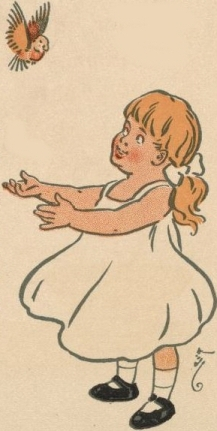

 "So this is where the
jolly bears live!" said
Golden Hair, as she knocked
upon the door. "I want
to meet them." No answer came to her knocking, so
she pushed the door wide open and
walked in. It was a most disorderly house,
but a bright fire burned on the hearth,
over which hung a big, black kettle of
bubbling soup, while on the table, near
by, were three yellow bowls of different
sizes. "A big bowl for Papa Bear, a medium
sized bowl for Mamma Bear, and a little
bowl for the Tiny Bear," said Golden Hair.


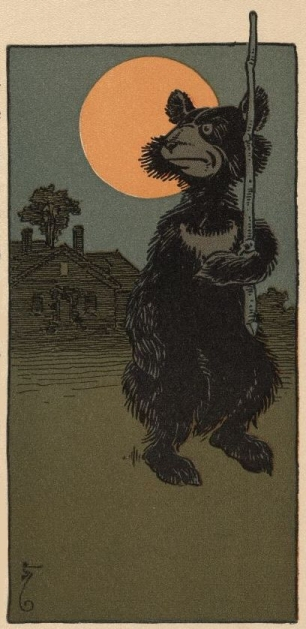

 Papa Bear would do
the chores and stand
guard over the house
at night; Mamma Bear
would do the housework under the direction
of Golden Hair, while the Tiny Bear
would wait upon grandmother and run
errands for the household. And so it came about that the
three
bears moved their three bowls and their


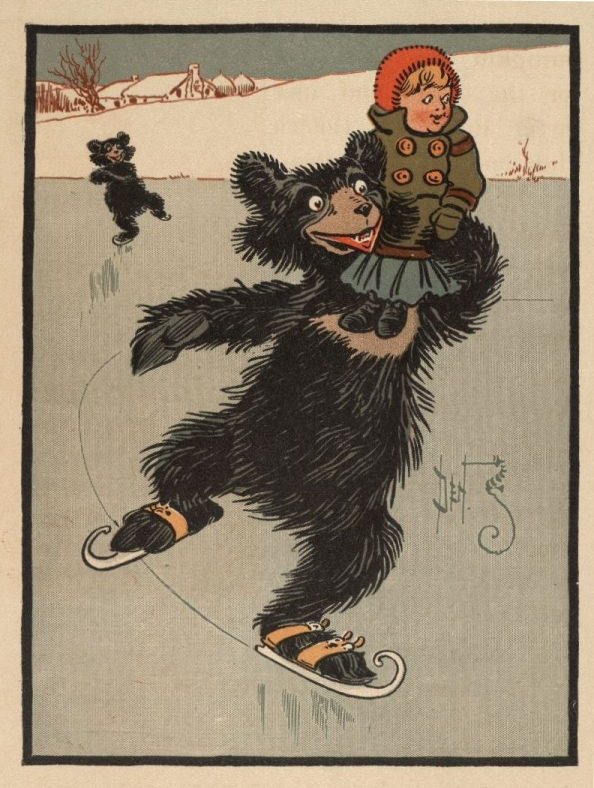

 three beds to the home of Golden Hair
and her grandmother, the very next day;
and from all accounts they were happy
ever after. At any rate the fame of
Golden Hair and the three bears spread
far and wide through all the countryside,
so that on holidays troops of children
came to play with the four jolly friends. The good natured bears were always
anxious to please the children; they
would get up games under the greenwood
trees in the summer, and merry


In [57]:
# Load results from database and S3
rows = result.all()
for row in rows:
    result = row[0]
    text = result.text
    image_path = result.image_path
    download_file_from_s3(
        bucket_name=SETTINGS.S3_BUCKET, object_key=image_path, file=image_path
    )
    image = Image.open(image_path)
    os.remove(image_path)

    display(image)
    print(text)